In [107]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.MDSS import MDSS

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings

warnings.filterwarnings('ignore')

In [108]:
data = pd.read_csv('../project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']
target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']

In [109]:
data.site.value_counts()

1    2486
3    2003
Name: site, dtype: int64

In [110]:
numeric_columns = [col for col in data.columns \
                     if (is_numeric_dtype(data[col])) \
                     & (col not in target_cols) \
                     & (data[col].nunique() > 10)]

In [111]:
site_id = 3 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1942, 25)
Size after removing records with missing targets:  (1942, 25)


In [112]:
dff.friedewald_ldl_c_c_qc.min()

-999.0

In [115]:
dff

,htn_jnc7_qc,diabetes_status_c_qc,ckd_c_qc,cadiovascular_current,bmi_c_qc,age,cimt_mean_max,cholesterol_1_qc,friedewald_ldl_c_c_qc,hdl_qc,...,site,sex,hiv_final_status_c,highest_level_of_education_qc,partnership_status_c_qc,ses_site_quintile_c_qc,occupation_qc,mvpa_cat_c,alcohol_use_status_c_qc,smoking_status_c_qc
361,0,0,0,0.0,23.83,57,0.640,5.71,4.070909,1.38,...,1,0,0,0,2,2,2,1.0,0,0
366,1,0,0,0.0,27.02,56,0.870,4.45,2.694545,1.46,...,1,0,0,1,2,4,4,1.0,0,0
367,0,0,0,0.0,20.34,56,0.760,3.72,2.255455,1.01,...,1,1,1,1,2,2,4,1.0,3,2
371,0,0,1,0.0,37.42,45,0.640,4.05,2.310909,1.13,...,1,0,0,3,1,5,2,1.0,0,0
375,0,0,0,0.0,16.33,43,0.635,2.03,0.787273,0.92,...,1,1,1,2,0,2,4,1.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,1,0,0,0.0,15.82,58,0.760,4.84,2.485455,2.00,...,1,1,1,0,1,2,4,1.0,1,1
4477,1,1,0,0.0,32.46,48,0.635,3.37,2.040000,1.08,...,1,1,0,2,1,4,3,0.0,0,0
4478,0,0,0,0.0,36.09,51,0.780,5.02,2.829091,1.70,...,1,1,0,0,1,1,4,0.0,1,0
4484,0,0,0,0.0,26.17,50,0.640,3.73,2.250909,1.17,...,1,1,0,1,1,5,4,1.0,3,0


In [114]:
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)]
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 25)
Size after removing records with missing targets:  (1465, 25)


In [116]:
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

<Axes: ylabel='Density'>

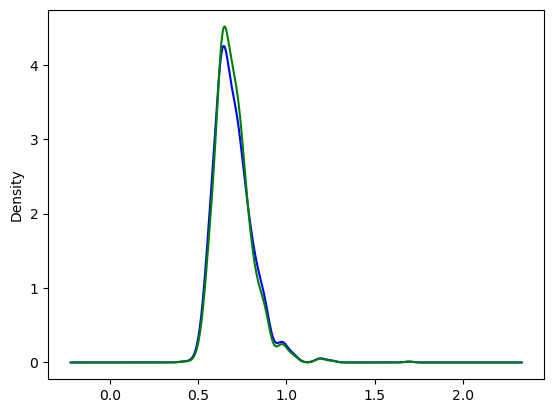

In [117]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1)
train_t = imputer.transform(dff1)
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff1['cimt_mean_max'].plot(kind='kde', ax=ax, color='blue')
treated['cimt_mean_max'].plot(kind='kde', ax=ax, color='green')

In [118]:
dff1['cimt_mean_max'].isnull().sum()

197

In [119]:
# treated.loc[:,['highest_level_of_education_qc']].apply(np.ceil).value_counts()
np.round(treated.loc[:,['occupation_qc']], decimals=0)

,occupation_qc
0,2.0
1,4.0
2,4.0
3,2.0
4,4.0
...,...
1460,4.0
1461,3.0
1462,4.0
1463,4.0


In [120]:
np.round(pd.DataFrame([2.3,2.5,2.1,2.7,2.9,2.15,2.58]), decimals=0).value_counts()

2.0    4
3.0    3
dtype: int64

In [121]:
target_col = 'diab_hyp'

# defining the target column to be a column where the sum of the target values >= 2
dff[target_col] = (dff[target_cols] == 1).sum(axis = 1) == 2

# defining the expectations as mean of the target
dff['expectation'] = dff[target_col].mean()
# dff['expectation'].head()

# target_col = 'diab_hyp'

# defining the target column to be a column where the sum of the target values >= 2
treated[target_col] = (treated[target_cols] == 1).sum(axis = 1) == 2

# defining the expectations as mean of the target
treated['expectation'] = treated[target_col].mean()

In [15]:
treated.loc[:,['diab_hyp','htn_jnc7_qc', 'diabetes_status_c_qc']]

,diab_hyp,htn_jnc7_qc,diabetes_status_c_qc
0,False,0.0,0.0
1,False,1.0,0.0
2,False,0.0,0.0
3,False,0.0,0.0
4,False,0.0,0.0
...,...,...,...
1460,False,1.0,0.0
1461,True,1.0,1.0
1462,False,0.0,0.0
1463,False,0.0,0.0


In [16]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space = [col for col in dff.columns \
                if col not in \
                [target_col, 'site', 'study_id', 'expectation', \
                'htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']]

In [17]:
search_space

['bmi_c_qc',
 'age',
 'cimt_mean_max',
 'cholesterol_1_qc',
 'friedewald_ldl_c_c_qc',
 'hdl_qc',
 'triglycerides_qc',
 'waist_hip_r_c_qc',
 'waist_circumference_qc',
 'visceral_fat_qc',
 'subcutaneous_fat_qc',
 'sex',
 'hiv_final_status_c',
 'highest_level_of_education_qc',
 'partnership_status_c_qc',
 'ses_site_quintile_c_qc',
 'occupation_qc',
 'mvpa_cat_c',
 'alcohol_use_status_c_qc',
 'smoking_status_c_qc']

In [18]:
len(search_space)

20

In [19]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser
            

In [20]:
contiguous = {}
dff_2 = dff.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

#### For treated missingness
Rerun the next cells and jump to next markdown cell

In [21]:
contiguous = {}
dff_2 = treated.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [22]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'

    return desc[:-5].replace('_',' ').replace('{', '(').replace('}', ')')

In [23]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'cholesterol_1_qc': ['0.3 - 2.78', '2.78 - 3.16', '3.16 - 3.47', '3.47 - 3.71', '3.71 - 3.99', '3.99 - 4.15', '4.15 - 4.46', '4.46 - 4.78'], 'bmi_c_qc': ['27.97 - 30.09', '30.09 - 32.59', '32.59 - 35.92', '35.92 - 68.02'], 'subcutaneous_fat_qc': ['1.54 - 1.82', '1.82 - 2.17', '2.17 - 2.54', '2.54 - 2.95', '2.95 - 4.28', '4.28 - 10.41'], 'ses_site_quintile_c_qc': [5.0], 'visceral_fat_qc': ['-0.74 - 2.82', '2.82 - 4.16', '4.16 - 4.87', '4.87 - 5.42', '5.42 - 5.91', '5.91 - 6.36', '6.36 - 6.85', '6.85 - 7.63', '7.63 - 8.64'], 'cimt_mean_max': ['0.62 - 0.64', '0.64 - 0.66', '0.66 - 0.68', '0.68 - 0.71', '0.71 - 0.74', '0.74 - 0.77', '0.77 - 0.83', '0.83 - 1.7'], 'waist_hip_r_c_qc': ['0.94 - 0.97', '0.97 - 1.0', '1.0 - 1.16'], 'age': ['42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0', '57.0 - 58.0']}, Score = 11.813000759857985
Penalty = 2: Subset = {'friedewald_ldl_c_c_qc': ['-3.31 - 1.37', '1.37 - 1.69', '1.69 - 

In [139]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)

penalty = 3
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 223 ms, sys: 67.3 ms, total: 290 ms
Wall time: 4.78 s


({'cimt_mean_max': ['0.74 - 0.77', '0.77 - 0.83', '0.83 - 1.7'],
  'waist_hip_r_c_qc': ['1.0 - 1.16']},
 12.187553177273294)

In [152]:
# function to get records of returned subset definition
def get_subset_dataframe(subset, data):
    """ 
    This function takes a subset definition and returns a dataframe of records specified in the subset.
    Parameters:
    subset (dict): A dictionary where each key-value pair represents a column name and its corresponding
    value to filter the dataframe.
    data (pd.DataFrame): The original pandas dataframe from which the subset is to be extracted.
    Returns:
    pd.DataFrame: A new dataframe containing only the records that match the specified subset criteria.
    """
    # select indices of column/value pairs in the subset description from the original dataset
    to_choose = data[subset[0].keys()].isin(subset[0]).all(axis=1)
    # slice indices from original dataset and reset the index
    subset_df = data.loc[to_choose].reset_index(drop=True)

    return subset_df
subset_df = get_subset_dataframe(subset,dff)
subset_df.head()

KeyError: 0

In [154]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 50 
Recall that our population average is 0.05051194539249147      
In this subgroup, we observe a mean outcome of 0.32
With 16 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 8.846


In [28]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]

# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0', '780.0 - 810.0', '810.0 - 860.0', '860.0 - 900.0', '900.0 - 950.0', '950.0 - 990.0'], 'highest_level_of_education_qc': [0.0, 2.0], 'occupation_qc': [2.0, 3.0, 4.0], 'visceral_fat_qc': ['2.82 - 4.16', '4.16 - 4.87', '4.87 - 5.42', '5.42 - 5.91', '5.91 - 6.36', '6.36 - 6.85', '6.85 - 7.63'], 'triglycerides_qc': ['0.46 - 0.55', '0.55 - 0.63', '0.63 - 0.71', '0.71 - 0.8', '0.8 - 0.89', '0.89 - 0.98', '0.98 - 1.12', '1.12 - 1.47', '1.47 - 5.34']}, Score = 9.4674689699748
Penalty = 2: Subset = {'age': ['40.0 - 42.0', '42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0'], 'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 10.56486285033507
Penalty = 3: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 9.509913245048368
Penalty = 4: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score 

In [29]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)

penalty = 3
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 317 ms, sys: 90.3 ms, total: 407 ms
Wall time: 5.19 s


({'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']},
 9.509913245048368)

In [30]:
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

waist circumference qc = (510.0 - 780.0)


In [31]:
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average\
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 315 
Recall that our population average is 0.05051194539249148      
In this subgroup, we observe a mean outcome of 0.003
With 1 individuals in the group above average      
This is a multiplicative factor in the odds (i.e q) of 0.06


### AS for treated missingness

In [32]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'cholesterol_1_qc': ['0.3 - 2.78', '2.78 - 3.16', '3.16 - 3.47', '3.47 - 3.71', '3.71 - 3.99', '3.99 - 4.15', '4.15 - 4.46', '4.46 - 4.78'], 'bmi_c_qc': ['27.97 - 30.09', '30.09 - 32.59', '32.59 - 35.92', '35.92 - 68.02'], 'subcutaneous_fat_qc': ['1.54 - 1.82', '1.82 - 2.17', '2.17 - 2.54', '2.54 - 2.95', '2.95 - 4.28', '4.28 - 10.41'], 'ses_site_quintile_c_qc': [5.0], 'visceral_fat_qc': ['-0.74 - 2.82', '2.82 - 4.16', '4.16 - 4.87', '4.87 - 5.42', '5.42 - 5.91', '5.91 - 6.36', '6.36 - 6.85', '6.85 - 7.63', '7.63 - 8.64'], 'cimt_mean_max': ['0.62 - 0.64', '0.64 - 0.66', '0.66 - 0.68', '0.68 - 0.71', '0.71 - 0.74', '0.74 - 0.77', '0.77 - 0.83', '0.83 - 1.7'], 'waist_hip_r_c_qc': ['0.94 - 0.97', '0.97 - 1.0', '1.0 - 1.16'], 'age': ['42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0', '57.0 - 58.0']}, Score = 11.813000759857985
Penalty = 2: Subset = {'friedewald_ldl_c_c_qc': ['-3.31 - 1.37', '1.37 - 1.69', '1.69 - 

In [33]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)

penalty = 7
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 275 ms, sys: 77.1 ms, total: 352 ms
Wall time: 4.26 s


({'cimt_mean_max': ['0.74 - 0.77', '0.77 - 0.83', '0.83 - 1.7'],
  'waist_hip_r_c_qc': ['1.0 - 1.16']},
 4.187553177273294)

In [34]:
# print the subset we obtained as a rule
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

cimt mean max = (0.74 - 1.7) AND
waist hip r c qc = (1.0 - 1.16)


In [35]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 50 
Recall that our population average is 0.05051194539249147      
In this subgroup, we observe a mean outcome of 0.32
With 16 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 8.846


In [36]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]

# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0', '780.0 - 810.0', '810.0 - 860.0', '860.0 - 900.0', '900.0 - 950.0', '950.0 - 990.0'], 'highest_level_of_education_qc': [0.0, 2.0], 'occupation_qc': [2.0, 3.0, 4.0], 'visceral_fat_qc': ['2.82 - 4.16', '4.16 - 4.87', '4.87 - 5.42', '5.42 - 5.91', '5.91 - 6.36', '6.36 - 6.85', '6.85 - 7.63'], 'triglycerides_qc': ['0.46 - 0.55', '0.55 - 0.63', '0.63 - 0.71', '0.71 - 0.8', '0.8 - 0.89', '0.89 - 0.98', '0.98 - 1.12', '1.12 - 1.47', '1.47 - 5.34']}, Score = 9.4674689699748
Penalty = 2: Subset = {'age': ['40.0 - 42.0', '42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0'], 'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 10.56486285033507
Penalty = 3: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 9.509913245048368
Penalty = 4: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score 

In [37]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)

penalty = 6
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 298 ms, sys: 80.6 ms, total: 378 ms
Wall time: 3.36 s


({'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']},
 6.509913245048368)

In [38]:
# print the subset we obtained as a rule
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

waist circumference qc = (510.0 - 780.0)


In [39]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 315 
Recall that our population average is 0.05051194539249148      
In this subgroup, we observe a mean outcome of 0.003
With 1 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 0.06


In [164]:
dff.head()

,htn_jnc7_qc,diabetes_status_c_qc,ckd_c_qc,cadiovascular_current,bmi_c_qc,age,cimt_mean_max,cholesterol_1_qc,friedewald_ldl_c_c_qc,hdl_qc,...,hiv_final_status_c,highest_level_of_education_qc,partnership_status_c_qc,ses_site_quintile_c_qc,occupation_qc,mvpa_cat_c,alcohol_use_status_c_qc,smoking_status_c_qc,diab_hyp,expectation
361,0,0,0,0.0,23.83,57,0.640,5.71,4.070909,1.38,...,0,0,2,2,2,1.0,0,0,False,0.050512
366,1,0,0,0.0,27.02,56,0.870,4.45,2.694545,1.46,...,0,1,2,4,4,1.0,0,0,False,0.050512
367,0,0,0,0.0,20.34,56,0.760,3.72,2.255455,1.01,...,1,1,2,2,4,1.0,3,2,False,0.050512
371,0,0,1,0.0,37.42,45,0.640,4.05,2.310909,1.13,...,0,3,1,5,2,1.0,0,0,False,0.050512
375,0,0,0,0.0,16.33,43,0.635,2.03,0.787273,0.92,...,1,2,0,2,4,1.0,1,2,False,0.050512


In [165]:
dff_2.head()

,htn_jnc7_qc,diabetes_status_c_qc,ckd_c_qc,cadiovascular_current,bmi_c_qc,age,cimt_mean_max,cholesterol_1_qc,friedewald_ldl_c_c_qc,hdl_qc,...,hiv_final_status_c,highest_level_of_education_qc,partnership_status_c_qc,ses_site_quintile_c_qc,occupation_qc,mvpa_cat_c,alcohol_use_status_c_qc,smoking_status_c_qc,diab_hyp,expectation
0,0.0,0.0,0.0,0.0,22.99 - 24.46,55.0 - 57.0,0.62 - 0.64,5.31 - 9.97,3.54 - 7.6,1.29 - 1.44,...,0.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,False,0.050512
1,1.0,0.0,0.0,0.0,26.06 - 27.97,55.0 - 57.0,0.83 - 1.7,4.15 - 4.46,2.49 - 2.79,1.44 - 1.66,...,0.0,1.0,2.0,4.0,4.0,1.0,0.0,0.0,False,0.050512
2,0.0,0.0,0.0,0.0,19.71 - 21.35,55.0 - 57.0,0.74 - 0.77,3.71 - 3.99,2.14 - 2.37,1.0 - 1.08,...,1.0,1.0,2.0,2.0,4.0,1.0,3.0,2.0,False,0.050512
3,0.0,0.0,1.0,0.0,35.92 - 68.02,44.0 - 47.0,0.62 - 0.64,3.99 - 4.15,2.14 - 2.37,1.08 - 1.17,...,0.0,3.0,1.0,5.0,2.0,1.0,0.0,0.0,False,0.050512
4,0.0,0.0,0.0,0.0,14.53 - 19.71,42.0 - 44.0,0.62 - 0.64,0.3 - 2.78,-3.31 - 1.37,0.81 - 0.93,...,1.0,2.0,0.0,2.0,4.0,1.0,1.0,2.0,False,0.050512


In [170]:
temp_df.head()

,htn_jnc7_qc,diabetes_status_c_qc,ckd_c_qc,cadiovascular_current,bmi_c_qc,age,cimt_mean_max,cholesterol_1_qc,friedewald_ldl_c_c_qc,hdl_qc,...,hiv_final_status_c,highest_level_of_education_qc,partnership_status_c_qc,ses_site_quintile_c_qc,occupation_qc,mvpa_cat_c,alcohol_use_status_c_qc,smoking_status_c_qc,diab_hyp,expectation
6,1.0,0.0,0.0,0.0,22.99 - 24.46,55.0 - 57.0,0.83 - 1.7,0.3 - 2.78,-3.31 - 1.37,0.81 - 0.93,...,0.0,3.0,0.0,4.0,2.0,1.0,0.0,0.0,False,0.050512
10,1.0,0.0,0.0,0.0,27.97 - 30.09,51.0 - 53.0,0.74 - 0.77,3.71 - 3.99,1.92 - 2.14,0.93 - 1.0,...,0.0,0.0,1.0,2.0,2.0,1.0,3.0,0.0,False,0.050512
65,0.0,0.0,0.0,0.0,27.97 - 30.09,55.0 - 57.0,0.74 - 0.77,3.47 - 3.71,1.92 - 2.14,0.81 - 0.93,...,0.0,0.0,1.0,2.0,4.0,0.0,0.0,0.0,False,0.050512
100,1.0,0.0,0.0,0.0,35.92 - 68.02,55.0 - 57.0,0.77 - 0.83,2.78 - 3.16,-3.31 - 1.37,1.08 - 1.17,...,0.0,0.0,1.0,2.0,4.0,0.0,0.0,0.0,False,0.050512
172,0.0,1.0,0.0,1.0,30.09 - 32.59,58.0 - 60.0,0.77 - 0.83,4.15 - 4.46,2.37 - 2.49,1.29 - 1.44,...,0.0,0.0,2.0,5.0,3.0,1.0,0.0,0.0,False,0.050512


In [168]:
list(temp_df.index)


[6,
 10,
 65,
 100,
 172,
 174,
 215,
 220,
 227,
 240,
 272,
 328,
 331,
 342,
 399,
 412,
 427,
 533,
 558,
 575,
 588,
 667,
 678,
 730,
 731,
 828,
 882,
 884,
 899,
 912,
 921,
 979,
 981,
 996,
 1048,
 1057,
 1184,
 1186,
 1246,
 1295,
 1297,
 1299,
 1302,
 1320,
 1322,
 1350,
 1396,
 1408,
 1439,
 1458]

In [177]:
import plotly.graph_objects as go


source = [
                    0,
                    1,
                    1,
                    1,
                    1,
                    6,
                    7,
                    8,
                    10,
                    9,
                    11,
                    11,
                    11,
                    15,
                    15,
                    15,
                    15,
                    15,
                    15,
                    15,
                    15,
                    15,
                    15,
                    15,
                    23,
                    25,
                    5,
                    5,
                    5,
                    5,
                    5,
                    27,
                    17,
                    17,
                    28,
                    29,
                    2,
                    2,
                    2,
                    2,
                    2,
                    2,
                    2,
                    2,
                    34,
                    24,
                    35,
                    35,
                    36,
                    38,
                    37,
                    39,
                    39,
                    40,
                    40,
                    41,
                    42,
                    43,
                    43,
                    4,
                    4,
                    4,
                    26,
                    26,
                    26,
                    44,
                    45,
                    46,
                    47,
                    35,
                    35
                ]
target = [
                    1,
                    2,
                    3,
                    4,
                    5,
                    2,
                    4,
                    9,
                    9,
                    4,
                    12,
                    13,
                    14,
                    16,
                    14,
                    17,
                    12,
                    18,
                    19,
                    13,
                    3,
                    20,
                    21,
                    22,
                    24,
                    24,
                    13,
                    3,
                    26,
                    19,
                    12,
                    15,
                    28,
                    3,
                    18,
                    15,
                    12,
                    30,
                    18,
                    31,
                    32,
                    19,
                    33,
                    20,
                    1,
                    5,
                    26,
                    26,
                    37,
                    37,
                    2,
                    4,
                    1,
                    14,
                    13,
                    15,
                    14,
                    42,
                    41,
                    19,
                    26,
                    12,
                    15,
                    3,
                    11,
                    15,
                    1,
                    15,
                    15,
                    26,
                    26
                ]
value = [
                    124.729,
                    0.597,
                    26.862,
                    280.322,
                    81.144,
                    35,
                    35,
                    11.606,
                    63.965,
                    75.571,
                    10.639,
                    22.505,
                    46.184,
                    104.453,
                    113.726,
                    27.14,
                    342.165,
                    37.797,
                    4.412,
                    40.858,
                    56.691,
                    7.863,
                    90.008,
                    93.494,
                    40.719,
                    82.233,
                    0.129,
                    1.401,
                    151.891,
                    2.096,
                    48.58,
                    7.013,
                    20.897,
                    6.242,
                    20.897,
                    6.995,
                    121.066,
                    128.69,
                    135.835,
                    14.458,
                    206.267,
                    3.64,
                    33.218,
                    4.413,
                    14.375,
                    122.952,
                    500,
                    139.978,
                    504.287,
                    107.703,
                    611.99,
                    56.587,
                    77.81,
                    193.026,
                    70.672,
                    59.901,
                    19.263,
                    19.263,
                    59.901,
                    0.882,
                    400.12,
                    46.477,
                    525.531,
                    787.129,
                    79.329,
                    9.452,
                    182.01,
                    19.013,
                    289.366,
                    100,
                    100
                ]

link = dict(source = source, target = target, value = value)
data = go.Sankey(link = link)

fig = go.Figure(data)

fig.show()

In [174]:
len(target)

71